In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.impute import SimpleImputer

In [3]:
df = pd.read_csv("Dataset.csv")
df_orig = df[:]

In [4]:
pd.set_option('display.max_columns', df.shape[1])
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# df.head()

In [5]:
# df.info()
df.describe()

,Unnamed: 0,Id,year,price,distance_travelled(kms),brand_rank,car_age,distance below 30k km,new and less used,inv_car_price,inv_car_dist,inv_car_age,inv_brand,std_invprice,std_invdistance_travelled,std_invrank,best_buy1,best_buy2
count,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00,1725.00
mean,862.00,862.00,2015.39,1494837.39,53848.26,15.73,5.61,0.27,0.21,0.00,0.00,inf,0.19,0.08,0.01,0.18,88.96,32.54
std,498.11,498.11,3.21,1671657.73,44725.54,12.95,3.21,0.44,0.41,0.00,0.00,NaN,0.25,0.08,0.04,0.26,188.95,158.66
min,0.00,0.00,1990.00,62500.00,350.00,1.00,0.00,0.00,0.00,0.00,0.00,0.03,0.01,0.00,0.00,0.00,0.00,0.00
25%,431.00,431.00,2013.00,545000.00,29000.00,5.00,3.00,0.00,0.00,0.00,0.00,0.12,0.04,0.03,0.00,0.03,14.24,0.00
50%,862.00,862.00,2016.00,875000.00,49000.00,14.00,5.00,0.00,0.00,0.00,0.00,0.20,0.07,0.07,0.01,0.06,36.72,0.00
75%,1293.00,1293.00,2018.00,1825000.00,70500.00,24.00,8.00,1.00,0.00,0.00,0.00,0.33,0.20,0.11,0.01,0.19,90.78,0.00
max,1724.00,1724.00,2021.00,14700000.00,790000.00,81.00,31.00,1.00,1.00,0.00,0.00,inf,1.00,1.00,1.00,1.00,2477.52,2477.52


In [ ]:
# checking for nulls in each column
df.isnull().sum()

In [7]:
# drop some repeating cols
df = df.drop(['Unnamed: 0', 'Id'], axis=1)
# df.columns
df.head(0)

,year,brand,full_model_name,model_name,price,distance_travelled(kms),fuel_type,city,brand_rank,car_age,distance below 30k km,new and less used,inv_car_price,inv_car_dist,inv_car_age,inv_brand,std_invprice,std_invdistance_travelled,std_invrank,best_buy1,best_buy2


In [8]:
def get_heat_map_corr(corr_df, figsize=(10, 9), remove_cols=[], corr_method='pearson', title=None, mirrored=False):

    df_temp = corr_df
    for i in remove_cols:
        try:
            df_temp = df_temp.drop(i,axis=1)
        except:
            print(f'column {i} not found')
    
    for c in df_temp.columns:
        if df_temp[c].dtype == 'object':
            df_temp = df_temp.drop(c,axis=1)

    corr = df_temp.corr(method=corr_method)

    f, ax = plt.subplots(figsize=figsize)

    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    if title != None:
        plt.title(title)

    if mirrored == False:
        sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)
    else:
        sns.heatmap(corr, annot=True, cmap=cmap)

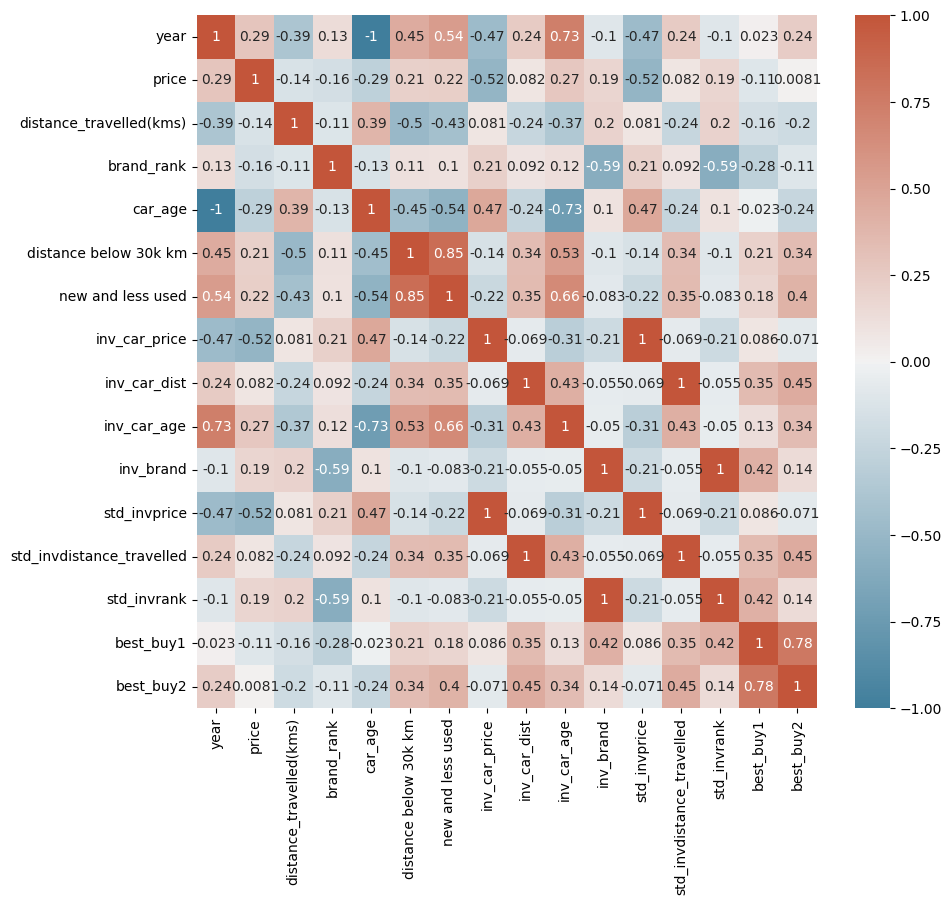

In [9]:
# get_heat_map_corr of df without column of object dtype
get_heat_map_corr(df, mirrored=True)

Text(0.5, 1.0, 'inv_brand || std_invrank')

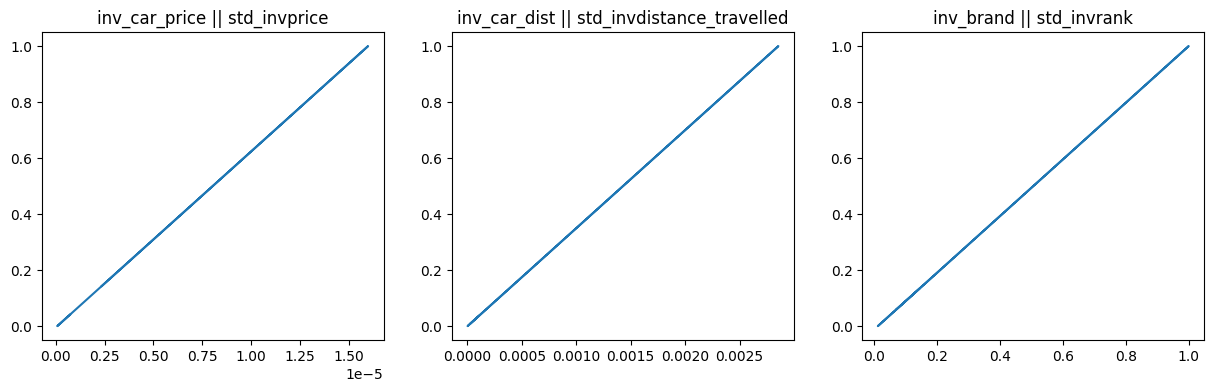

In [10]:
# plotting the columns with correlation = 1, meaning they have same data, one of correlation columns can be ommited for ML
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

axes[0].plot( df['inv_car_price'], df['std_invprice'] )
axes[0].set_title( 'inv_car_price || std_invprice')

axes[1].plot( df['inv_car_dist'], df['std_invdistance_travelled'] )
axes[1].set_title( 'inv_car_dist || std_invdistance_travelled')

axes[2].plot( df['inv_brand'], df['std_invrank'] )
axes[2].set_title( 'inv_brand || std_invrank')

In [11]:
# delete correlating columns
corr_cols_to_del = [
    'std_invprice',
    'std_invdistance_travelled',
    'std_invrank',
]
df = df.drop(corr_cols_to_del, axis=1)
df.head(2)

,year,brand,full_model_name,model_name,price,distance_travelled(kms),fuel_type,city,brand_rank,car_age,distance below 30k km,new and less used,inv_car_price,inv_car_dist,inv_car_age,inv_brand,best_buy1,best_buy2
0,2016,Honda,Honda Brio S MT,Brio,425000.00,9680.00,Petrol,Mumbai,7,5.00,1,0,0.00,0.00,0.20,0.14,677.13,0.00
1,2012,Nissan,Nissan Sunny XV Diesel,Sunny,325000.00,119120.00,Diesel,Mumbai,11,9.00,0,0,0.00,0.00,0.11,0.09,37.50,0.00


In [12]:
# delete dublicates
df.duplicated().sum()
print(df.shape)
print(df.duplicated().sum())
df.drop_duplicates(keep = 'first', inplace = True)
print(df.shape)

(1725, 18)
425
(1300, 18)


In [13]:
# make label columns with object dtype
label = LabelEncoder()

cols_to_encode = [i for i in df.columns if df[i].dtype == 'object']
cols_to_encode

df_labeled = df[:]
for c in cols_to_encode:
    label.fit(df_labeled[c].drop_duplicates())
    df_labeled[c] = label.transform(df_labeled[c])
    # print(c, df_labeled[c].isnull().sum())

df_labeled.head(1)

,year,brand,full_model_name,model_name,price,distance_travelled(kms),fuel_type,city,brand_rank,car_age,distance below 30k km,new and less used,inv_car_price,inv_car_dist,inv_car_age,inv_brand,best_buy1,best_buy2
0,2016,7,131,28,425000.00,9680.00,3,9,7,5.00,1,0,0.00,0.00,0.20,0.14,677.13,0.00


column ['full_model_name', 'city', 'brand_rank', 'car_age', 'distance below 30k km', 'new and less used', 'inv_car_price', 'inv_car_dist', 'inv_car_age', 'inv_brand', 'std_invprice', 'std_invdistance_travelled', 'std_invrank', 'best_buy1', 'best_buy2'] not found


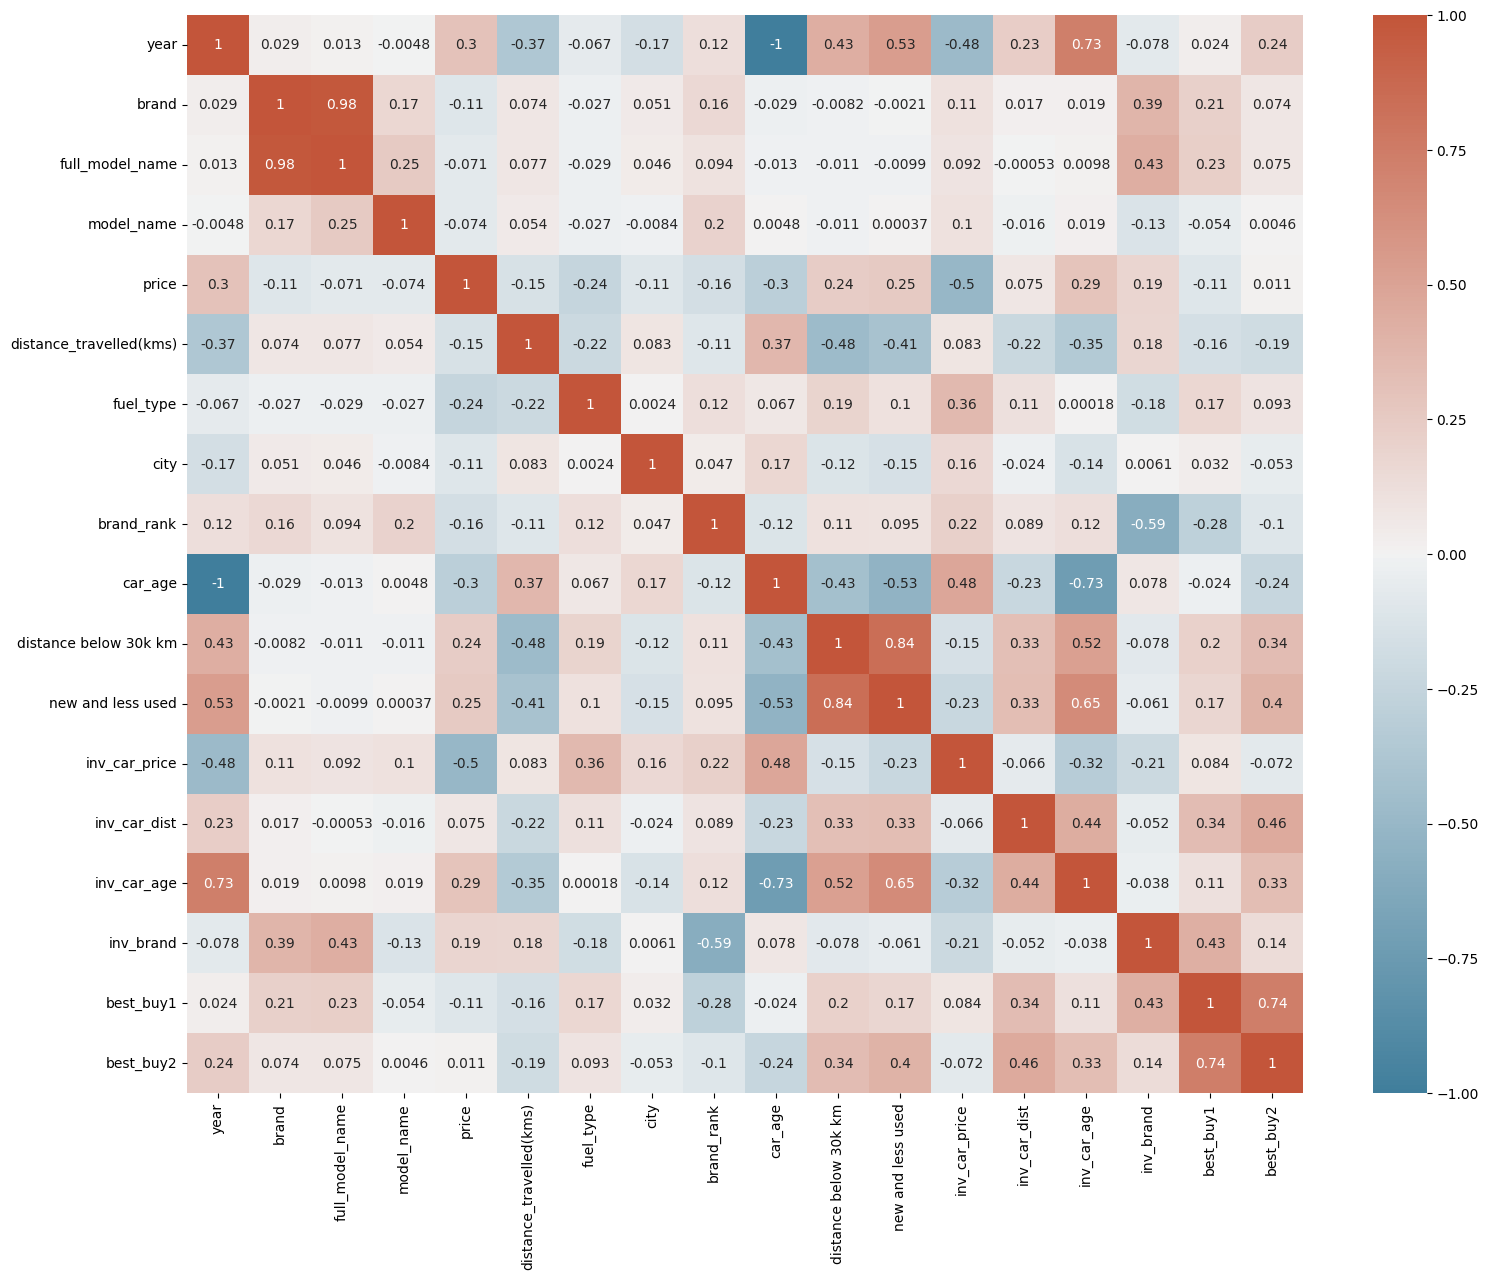

In [14]:
cols = ['full_model_name','city','brand_rank','car_age','distance below 30k km','new and less used','inv_car_price','inv_car_dist','inv_car_age','inv_brand','std_invprice','std_invdistance_travelled','std_invrank','best_buy1','best_buy2',]
get_heat_map_corr( df_labeled,figsize=(18,14) ,remove_cols=[cols], mirrored=True)
# df.columns

<Figure size 2000x2000 with 0 Axes>

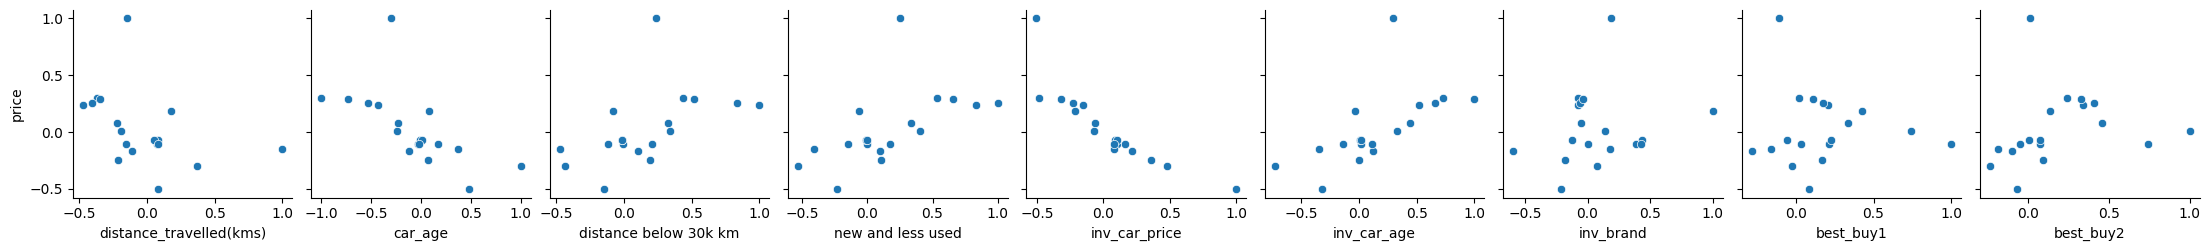

In [15]:
plt.figure(figsize=(20, 20))
sns.pairplot(
    df_labeled.corr(), 
    x_vars=[
        'distance_travelled(kms)',
        # 'fuel_type',
        'car_age',
        # 'brand_rank',
        'distance below 30k km',
        'new and less used',
        'inv_car_price',
        'inv_car_age',
        'inv_brand',
        'best_buy1',
        'best_buy2',],
    y_vars='price',
    kind='scatter',
    )

# df

In [16]:
def interquartile_range_method(df_col):
    sort_df_col = df_col.sort_values()
    q1 = sort_df_col.quantile(0.25)
    q3 = sort_df_col.quantile(0.75)
    iqr = q3 - q1
    upper_fence = q3 + (1.5 * iqr)
    lower_fence = q1 - (1.5 * iqr)
    outliers = ((sort_df_col < lower_fence) | (sort_df_col > upper_fence))
    print(f"[{sort_df_col.name}] outliers: {outliers.sum()}")
    return outliers

def statistical_outlier_detection(df_col, get=False, threshold = 3):
    data = df_col.to_numpy()
    mean,sigma = np.mean(data), np.std(data)     # standard deviation
    th = threshold
    z = (data - mean)
    z /= sigma
    outliers = data[z > th]
    print(f"[{df_col.name}] outliers: {len(outliers)}")
    if get == False:
        return len(outliers)
    else:
        return outliers

In [17]:
for i in df.columns:
    if  df[i].dtype != 'object':
        statistical_outlier_detection(df[i], threshold=4)

[year] outliers: 0
[price] outliers: 14
[distance_travelled(kms)] outliers: 5
[brand_rank] outliers: 10
[car_age] outliers: 1
[distance below 30k km] outliers: 0
[new and less used] outliers: 0
[inv_car_price] outliers: 11
[inv_car_dist] outliers: 5
[inv_car_age] outliers: 0
[inv_brand] outliers: 0
[best_buy1] outliers: 17
[best_buy2] outliers: 13


c:\Users\Dime\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\Dime\AppData\Local\Temp\ipykernel_25396\3970498793.py:16: RuntimeWarning: invalid value encountered in subtract
  z = (data - mean)


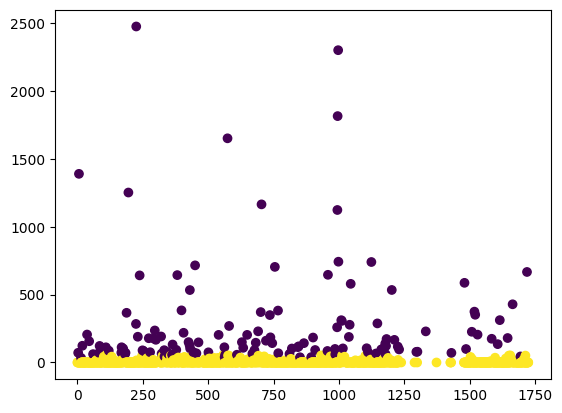

In [18]:
from sklearn.ensemble import IsolationForest

x = df["best_buy2"].values.reshape(-1, 1)  

clf = IsolationForest(contamination=0.1).fit(x)
clf.predict(x)
clf

predictions = clf.predict(x)
predictions

# plt.scatter(df.index, df["best_buy2"], color='red')
# plt.scatter(df.index, predictions)

plt.scatter(df.index, df["best_buy2"], c=predictions)

In [19]:
# dealing with outliers


x = df["best_buy2"].values.reshape(-1, 1)  
x.shape
x

clf = IsolationForest(contamination=0.1).fit(x)
clf.predict(x)
clf

predictions = clf.predict(x)
predictions


array([1, 1, 1, ..., 1, 1, 1])

c:\Users\Dime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


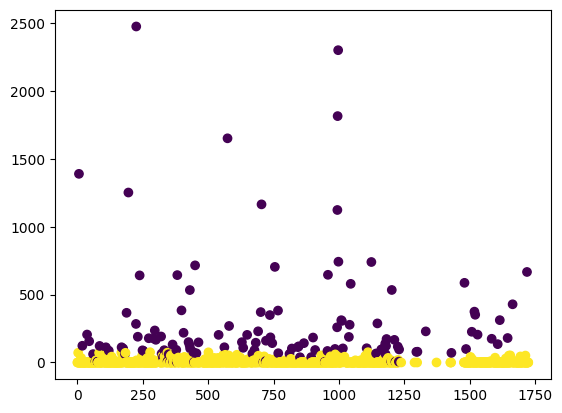

In [20]:
isf = IsolationForest(n_estimators=10)
clf = IsolationForest(contamination=0.1)
X = df[['best_buy2']]
clf.fit(X)
outliers = clf.predict(X)

plt.scatter(df.index, df["best_buy2"], c=outliers)

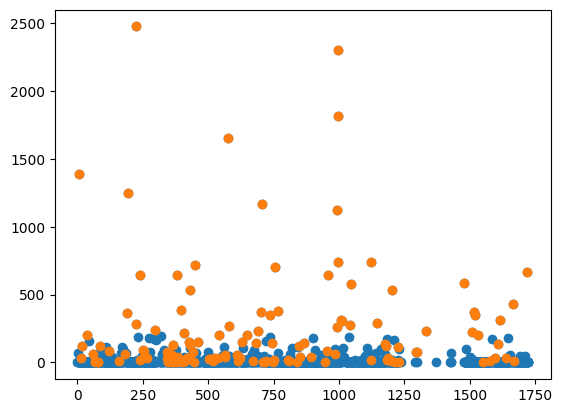

In [21]:
from sklearn.neighbors import LocalOutlierFactor

X = df[['best_buy2']]
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

outliers = clf.fit_predict(X)

plt.scatter(df.index, df['best_buy2'], label='Normal')
plt.scatter(df.index[outliers == -1], df.loc[outliers == -1, 'best_buy2'], label='Outlier')

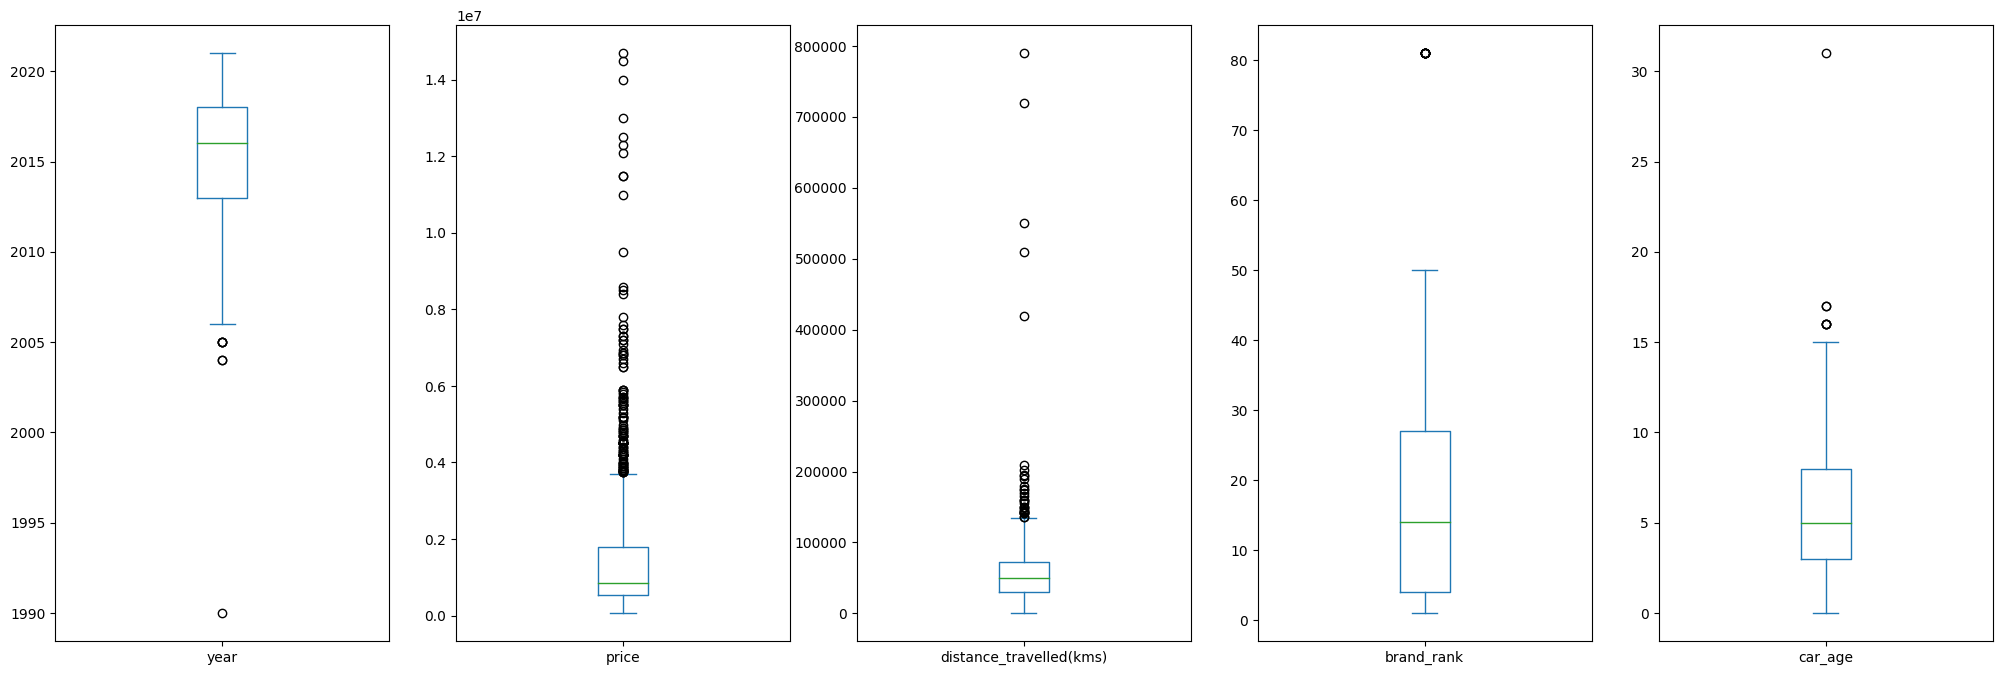

In [22]:
high_outliers = df[['year', 'price', 'distance_travelled(kms)', 'brand_rank', 'car_age']]
high_outliers.plot(kind='box',figsize=(25,8),subplots=True)
plt.show()
# plt.scatter(df['price'].index, df['price'])
# df['car_age'].value_counts()

inv_car_price       Axes(0.125,0.11;0.168478x0.77)
inv_car_dist     Axes(0.327174,0.11;0.168478x0.77)
best_buy1        Axes(0.529348,0.11;0.168478x0.77)
best_buy2        Axes(0.731522,0.11;0.168478x0.77)
dtype: object

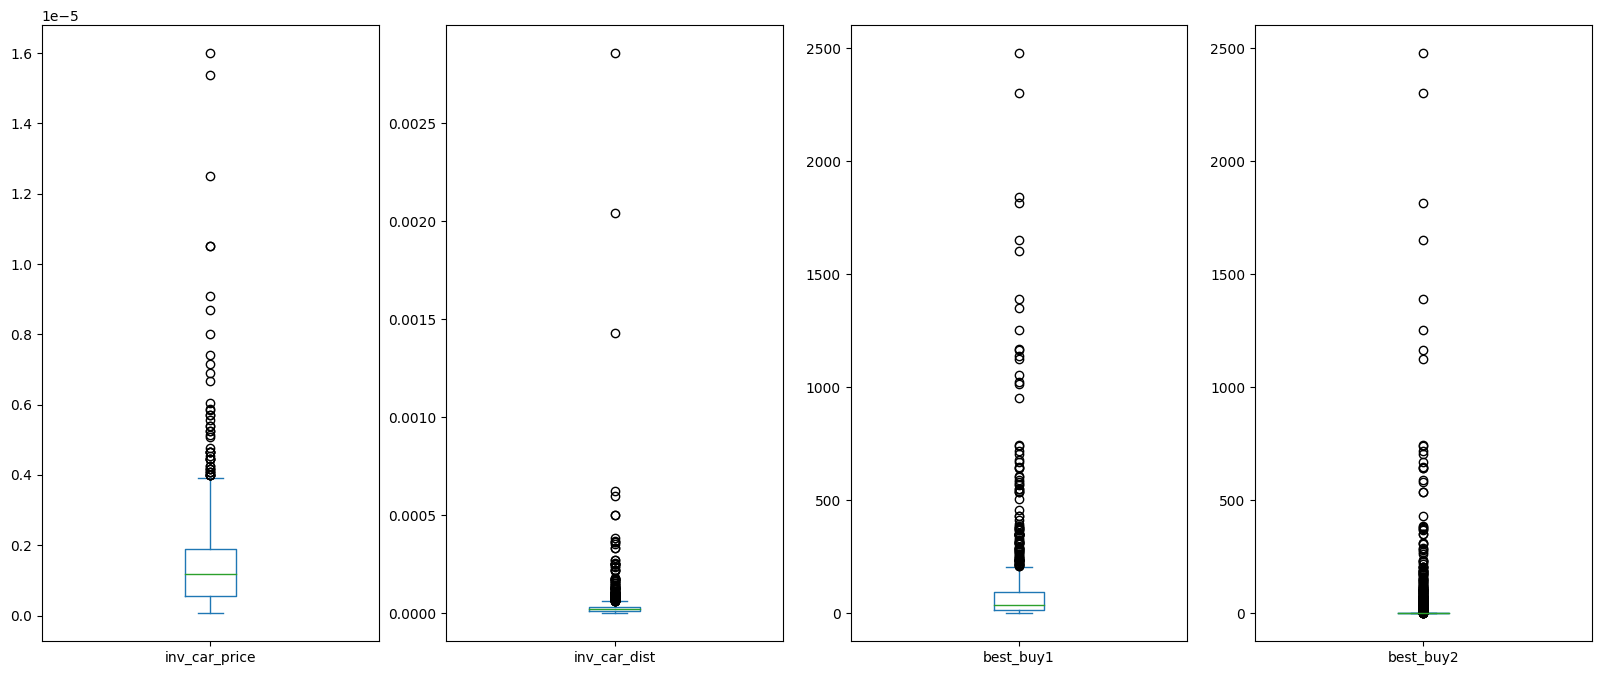

In [23]:
high_outliers = df[['inv_car_price', 'inv_car_dist', 'best_buy1', 'best_buy2']]
high_outliers.plot(kind='box',figsize=(20,8),subplots=True)

In [24]:
# high_outliers_cols_to_del = [
#     'inv_car_price',
#     'inv_car_dist',
#     'best_buy1',
#     'best_buy2',
# ]
# for c in high_outliers_cols_to_del:
#     ol = statistical_outlier_detection(df[c], True)
#     for i in set(ol):
#         # print(i)
#         df = df.drop(df[df[c] == i].index)
#         mean = df[c].mean()
#         df.loc[df[c] == i] = mean

In [25]:
outlier_detector = IsolationForest(contamination=0.05)

c='best_buy2'

X = df[[c]]
outlier_detector.fit(X)

outlier_mask = outlier_detector.predict(X)

# change outliers with nan to further replace with mean value of inliners
# X[outlier_mask == 1] = np.nan

df.loc[outlier_mask == -1, c] = np.nan

X.replace(np.nan, X.mean(), inplace=True)
df[c] = df[c].replace(np.nan, df[c].mean())

# df.loc[outlier_mask] =  np.nan

# df['column_name'] = np.where(outlier_mask == -1, np.nan, df['column_name'])

# # imputer = SimpleImputer(strategy='median')
# # imputer.fit(X)

# break

c:\Users\Dime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Dime\AppData\Local\Temp\ipykernel_25396\2051410522.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace(np.nan, X.mean(), inplace=True)


In [26]:
# dealing with outliers
outlier_detector = IsolationForest(contamination=0.05)

high_outliers_cols = ['inv_car_dist','inv_car_price','best_buy1','best_buy2']

for c in high_outliers_cols:
    X = df[[c]]
    outlier_detector.fit(X)

    outlier_mask = outlier_detector.predict(X)

    # change outliers with nan to further replace with mean value of inliners
    df.loc[outlier_mask == -1, c] = np.nan

    # replace with mean value of inliners
    df[c] = df[c].replace(np.nan, df[c].mean())

    # # imputer = SimpleImputer(strategy='median')
    # # imputer.fit(X)

c:\Users\Dime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\Dime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\Dime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
c:\Users\Dime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [27]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# axes[0].plot( df['inv_car_price'], df['std_invprice'] )
# axes[0].set_title( 'inv_car_price || std_invprice')

# plt.scatter(df['year'].index, df['year'])
# plt.scatter(df['price'].index, df['price'])

<Axes: ylabel='brand'>

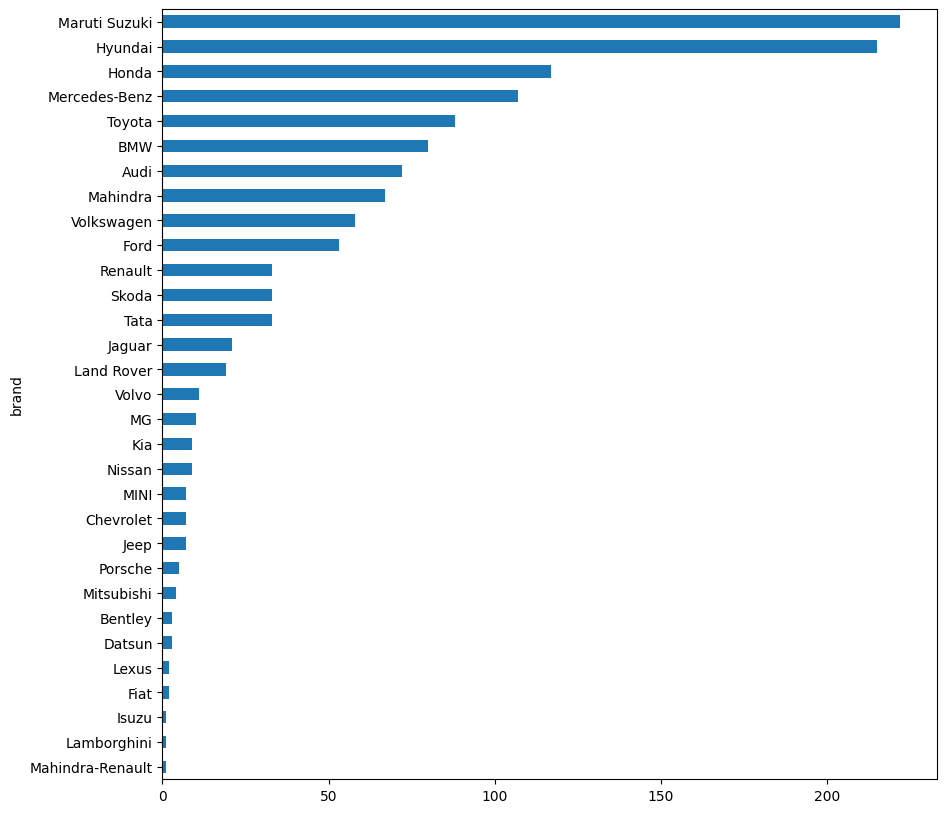

In [28]:
# plot top cars
df['brand'].value_counts().sort_values().plot(kind='barh', figsize=(10,10))

In [29]:
# deleting cars below year 2006, only 10 entries
# 4 car(s) for year 2005	
# 3 car(s) for year 2006	
# 2 car(s) for year 2004	
# 1 car(s) for year 1990	

df['year'].value_counts().reset_index()
df[df['year'] <= 2006].index
df[df['year'] <= 2006]
# df.shape
df = df.drop(index=df[df['year'] <= 2006].index)
df.shape

(1290, 18)

In [30]:
df.nunique()
# df.columns

year                         15
brand                        31
full_model_name             744
model_name                  167
price                       403
distance_travelled(kms)     641
fuel_type                     5
city                         15
brand_rank                   29
car_age                      15
distance below 30k km         2
new and less used             2
inv_car_price               365
inv_car_dist                597
inv_car_age                  15
inv_brand                    29
best_buy1                  1205
best_buy2                   118
dtype: int64

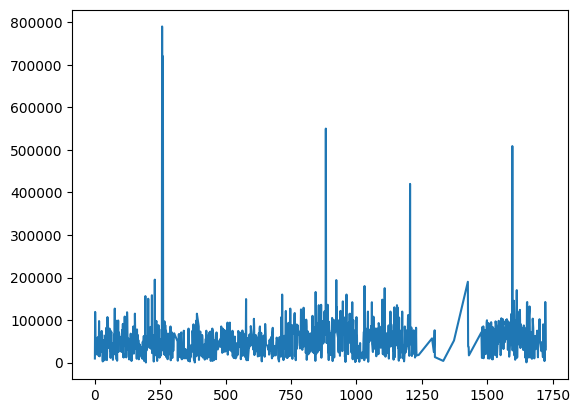

In [31]:
plt.plot(df['distance_travelled(kms)'].index, df['distance_travelled(kms)'])

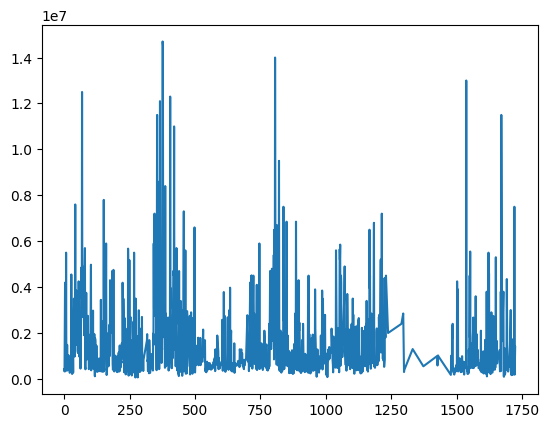

In [32]:
plt.plot(df['price'].index, df['price'])

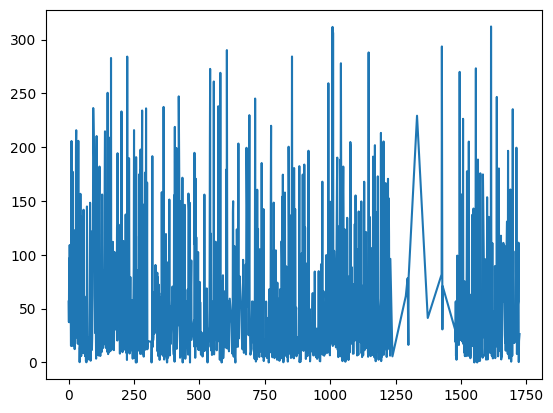

In [33]:
plt.plot(df['best_buy1'].index, df['best_buy1'])

In [34]:
df.duplicated().sum()

0

### logistic regression part

In [35]:
label = LabelEncoder()

cols_to_encode = [i for i in df.columns if df[i].dtype == 'object']
cols_to_encode

for c in cols_to_encode:
    label.fit(df[c].drop_duplicates())
    df[c] = label.transform(df[c])
    # print(c, df[c].isnull().sum())

df.head(2)

,year,brand,full_model_name,model_name,price,distance_travelled(kms),fuel_type,city,brand_rank,car_age,distance below 30k km,new and less used,inv_car_price,inv_car_dist,inv_car_age,inv_brand,best_buy1,best_buy2
0,2016,7,130,28,425000.00,9680.00,3,9,7,5.00,1,0,0.00,0.00,0.20,0.14,56.65,0.00
1,2012,23,567,127,325000.00,119120.00,1,9,11,9.00,0,0,0.00,0.00,0.11,0.09,37.50,0.00


In [36]:
# # log reg ideeas
# rank
# distance below 30k km / new and less used to other cols


In [37]:
X = df.drop('brand_rank',axis=1)
# xtra = ['inv_car_price','inv_car_dist','inv_car_age','inv_brand','best_buy1','best_buy2']
# X.drop(xtra,axis=1, inplace=True)
X

y = df['brand_rank']
y

0        7
1       11
2        1
3        2
4       14
        ..
1719     8
1720    14
1721    44
1722    24
1724    14
Name: brand_rank, Length: 1290, dtype: int64

In [38]:
# finding column with infinite value
for i in X.columns:
    inf = np.isinf(X[i]).values.sum()
    if inf != 0:
        print(inf, i)
        X[i].replace([np.inf, -np.inf], 0, inplace=True)
# X["inv_car_age"].value_counts()

16 inv_car_age


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y , train_size=.3, random_state=42)
print(f"X_train  {X_train.shape}")
print(f"X_test   {X_test.shape}")
print(f"y_train  {y_train.shape}")
print(f"y_test   {y_test.shape}")

X_train  (387, 17)
X_test   (903, 17)
y_train  (387,)
y_test   (903,)


In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### LogisticRegression().fit() with scaled data (higher acurracy)

In [41]:
# LogisticRegression().fit() with scaled data
# same accuracy regardless of LogisticRegression() args
clf = LogisticRegression(
    max_iter=600,
    fit_intercept=True,
    random_state = 100,
    verbose=5,
    )
clf.fit(X_train_scaled, y_train)

print(f"score: {clf.score(X_test_scaled, y_test)}")

score: 0.7973421926910299


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [42]:
# get sorted coef_ 
data = {}
for indx, col_name in enumerate(X_train):
    # print(col_name, lin_model.coef_[0][indx])
    # print(col_name, indx, lin_model.coef_[0][indx])
    data[col_name] = clf.coef_[0][indx]
data = dict(sorted(data.items(), key=lambda x: x[1],reverse=True))
data

{'inv_brand': 3.2316662812564236,
 'brand': 0.8536026549597959,
 'best_buy1': 0.757642943256712,
 'full_model_name': 0.7556488984946467,
 'distance_travelled(kms)': 0.3932050594530128,
 'inv_car_age': 0.24104257504345358,
 'year': 0.1558990546308261,
 'model_name': 0.11142199696963774,
 'inv_car_price': 0.08187027391185679,
 'best_buy2': 0.013185042184823585,
 'inv_car_dist': -0.024210893763321584,
 'new and less used': -0.030831532412652924,
 'city': -0.05384984875455008,
 'distance below 30k km': -0.07732749433061283,
 'car_age': -0.15589905463082576,
 'fuel_type': -0.2688973051904733,
 'price': -0.5848943956589542}

### LogisticRegression().fit() with raw data

In [43]:
clf = LogisticRegression(max_iter=600)
clf.fit(X_train, y_train)

print(f"score: {clf.score(X_test, y_test)}")

score: 0.21926910299003322


c:\Users\Dime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
y_pred = clf.predict(X_test)
# confusion_matrix(y_pred, y_test)

In [45]:
# get sorted coef_ 
data = {}
for indx, col_name in enumerate(X_train):
    # print(col_name, lin_model.coef_[0][indx])
    # print(col_name, indx, lin_model.coef_[0][indx])
    data[col_name] = clf.coef_[0][indx]
data = dict(sorted(data.items(), key=lambda x: x[1],reverse=True))
data

{'distance_travelled(kms)': 3.630564715541372e-05,
 'full_model_name': 6.1852692176249785e-06,
 'best_buy1': 1.0568476804785177e-06,
 'price': 5.561874042811691e-07,
 'brand': 2.3414673412682328e-07,
 'inv_brand': 3.127229304482004e-08,
 'inv_car_price': -5.251613431338858e-14,
 'inv_car_dist': -5.336556347575431e-13,
 'inv_car_age': -1.3195199660935592e-09,
 'new and less used': -2.8743095801336025e-09,
 'distance below 30k km': -5.504843941728323e-09,
 'best_buy2': -6.24453247613582e-08,
 'fuel_type': -6.667764233037969e-08,
 'city': -1.321011681380457e-07,
 'car_age': -1.65412317774699e-07,
 'model_name': -1.888789740795474e-06,
 'year': -4.1813562965927884e-05}

In [46]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
# auc_roc = roc_auc_score(y_test, y_pred, multi_class='ovr')

print(f"accuracy    {accuracy}")
print(f"precision   {precision}")
print(f"recall      {recall}")
print(f"f1          {f1}")

accuracy    0.21926910299003322
precision   0.019568029701121047
recall      0.05751038827263873
f1          0.026645056455459202


c:\Users\Dime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### logistic regression to 'new and less used' / 'distance below 30k km'

In [47]:
# strong positive correlation
df_orig['new and less used'].corr(df_orig['distance below 30k km'])

0.8468475041578979

In [48]:
X2 = df.drop(['new and less used', 'distance below 30k km','distance_travelled(kms)' ], axis=1)
# X2
y2 = df['new and less used']
# y2

In [49]:
# finding column with infinite value
for i in X2.columns:
    inf = np.isinf(X2[i]).values.sum()
    if inf != 0:
        print(inf, i)
        X2[i].replace([np.inf, -np.inf], 0, inplace=True)
# X["inv_car_age"].value_counts()

16 inv_car_age


In [50]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=.3)

In [51]:
# scaler = StandardScaler()
# X2_train_scaled = scaler.fit_transform(X2_train)
# X2_test_scaled = scaler.transform(X2_test)

In [52]:
clf2 = LogisticRegression(max_iter=600)
clf2.fit(X2_test, y2_test)

clf2.score(X2_test, y2_test)

0.7940199335548173

In [53]:
# get sorted coef_
data = {}
for indx, col_name in enumerate(X2_train):
    # print(col_name, lin_model.coef_[0][indx])
    # print(col_name, indx, lin_model.coef_[0][indx])
    data[col_name] = clf.coef_[0][indx]
data = dict(sorted(data.items(), key=lambda x: x[1],reverse=True))
data

{'fuel_type': 3.630564715541372e-05,
 'full_model_name': 6.1852692176249785e-06,
 'price': 5.561874042811691e-07,
 'brand': 2.3414673412682328e-07,
 'best_buy2': 3.127229304482004e-08,
 'inv_car_age': -5.251613431338858e-14,
 'inv_brand': -5.336556347575431e-13,
 'best_buy1': -1.3195199660935592e-09,
 'inv_car_dist': -2.8743095801336025e-09,
 'inv_car_price': -5.504843941728323e-09,
 'city': -6.667764233037969e-08,
 'brand_rank': -1.321011681380457e-07,
 'car_age': -1.65412317774699e-07,
 'model_name': -1.888789740795474e-06,
 'year': -4.1813562965927884e-05}

In [54]:
y2_pred = clf2.predict(X2_test)
confusion_matrix(y2_pred, y2_test)

array([[694, 171],
       [ 15,  23]], dtype=int64)

In [55]:
accuracy = accuracy_score(y2_test, y2_pred)
precision = precision_score(y2_test, y2_pred, average='macro')
recall = recall_score(y2_test, y2_pred, average='macro')
f1 = f1_score(y2_test, y2_pred, average='macro')
auc_roc = roc_auc_score(y2_test, y2_pred, multi_class='ovr')

print(f"accuracy    {accuracy}")
print(f"precision   {precision}")
print(f"recall      {recall}")
print(f"f1          {f1}")
print(f"auc_roc     {auc_roc}")

accuracy    0.7940199335548173
precision   0.7037876483115303
recall      0.5487000712488913
f1          0.5400527976164395
auc_roc     0.5487000712488913
